In [2]:
import pandas as pd 
import os
import numpy as np
import tifffile
from PIL import Image

In [3]:
!pip install imgaug

In [4]:

# Paths

image_dir = "/kaggle/input/floodd/data/images"
mask_dir = "/kaggle/input/floodd/data/labels"

In [5]:
import os
import numpy as np
import tifffile
from PIL import Image

# Paths
image_dir = "/kaggle/input/floodd/data/images"
mask_dir = "/kaggle/input/floodd/data/labels"

# Get file lists (make sure they match by name or order)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

images = []
masks = []

for img_file, mask_file in zip(image_files, mask_files):
    # Read TIFF image
    img_path = os.path.join(image_dir, img_file)
    image = tifffile.imread(img_path)

    # Read PNG mask
    mask_path = os.path.join(mask_dir, mask_file)
    mask = np.array(Image.open(mask_path))  # keeps mask as array

    images.append(image)
    masks.append(mask)

# Convert to numpy arrays
images = np.array(images)
masks = np.array(masks)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Images shape: (306, 128, 128, 12)
Masks shape: (306, 128, 128)


In [6]:
masks = masks.astype(np.float32)
# Add channel dimension to masks
masks = np.expand_dims(masks, axis=-1)

print("Fixed Images shape:", images.shape)
print("Fixed Masks shape:", masks.shape)

Fixed Images shape: (306, 128, 128, 12)
Fixed Masks shape: (306, 128, 128, 1)


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Images shape: (794, 128, 128, 12)
# Masks shape: (794, 128, 128)

X = images  
Y = masks   
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42, shuffle=True
)  


#  Validation + Test
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, shuffle=True
)  
#  Validation = 15% ، Test = 15%

print("Train:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Test:", X_test.shape, Y_test.shape)


Train: (214, 128, 128, 12) (214, 128, 128, 1)
Validation: (46, 128, 128, 12) (46, 128, 128, 1)
Test: (46, 128, 128, 12) (46, 128, 128, 1)


Updated Masks shape: (306, 128, 128, 1)


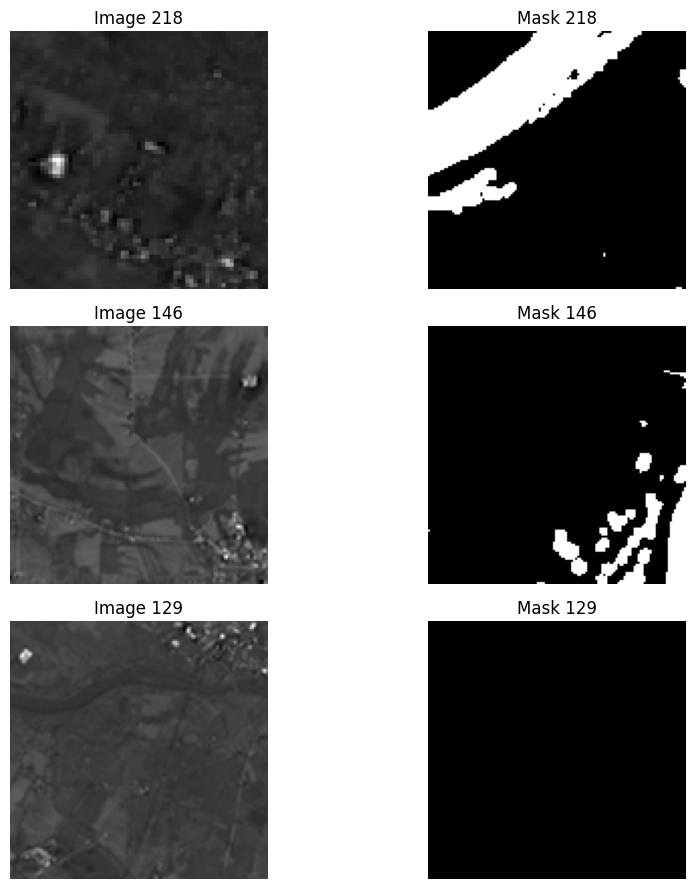

In [8]:
import matplotlib.pyplot as plt
import random

# Ensure masks have channel dimension (for visualization and training)
if masks.ndim == 3:  # (N, H, W)
    masks = np.expand_dims(masks, axis=-1)

print("Updated Masks shape:", masks.shape)

# Function to visualize random samples
def visualize_samples(images, masks, num_samples=3):
    indices = random.sample(range(len(images)), num_samples)
    
    plt.figure(figsize=(10, num_samples * 3))
    for i, idx in enumerate(indices):
        image = images[idx]
        mask = masks[idx].squeeze()  # remove channel dim if present

        # Show image
        plt.subplot(num_samples, 2, 2*i + 1)
        if image.shape[-1] == 1:  # grayscale
            plt.imshow(image.squeeze(), cmap="gray")
        else:  # multi-channel, just show first channel for quick check
            plt.imshow(image[..., 0], cmap="gray")
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Show mask
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_samples(images, masks, num_samples=3)


In [9]:
X = np.array(images, dtype=np.float32)
Y = np.array(masks, dtype=np.float32)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [11]:
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(244, 128, 128, 12) (62, 128, 128, 12) (244, 128, 128, 1) (62, 128, 128, 1)


In [12]:
import numpy as np
import imgaug.augmenters as iaa

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),                # flip horizontally
    iaa.Flipud(0.5),                # flip vertically
    iaa.Affine(rotate=(-20, 20)),   # random rotations
    iaa.Affine(scale=(0.9, 1.1)),   # zoom in/out
    iaa.ElasticTransformation(alpha=50, sigma=5), # elastic deformations
    iaa.GaussianBlur(sigma=(0, 1.0)) # blur images a bit
], random_order=True)

# Augment images and masks together
def augment_data(X_train, Y_train, n_aug=2):
    """
    Augment X_train, Y_train using imgaug
    n_aug = how many augmented copies per image
    """
    X_aug, Y_aug = [], []

    for i in range(len(X_train)):
        for _ in range(n_aug):
            # Apply the same augmentation to image and mask
            det = seq.to_deterministic()
            img_aug = det.augment_image(X_train[i])
            mask_aug = det.augment_image(Y_train[i])

            X_aug.append(img_aug)
            Y_aug.append(mask_aug)

    # Convert back to numpy
    X_aug = np.array(X_aug)
    Y_aug = np.array(Y_aug)

    # Concatenate with original data
    X_out = np.concatenate([X_train, X_aug], axis=0)
    Y_out = np.concatenate([Y_train, Y_aug], axis=0)

    return X_out, Y_out

# Example usage:
X_train_aug, Y_train_aug = augment_data(X_train, Y_train, n_aug=3)

print("Original:", X_train.shape, Y_train.shape)
print("Augmented:", X_train_aug.shape, Y_train_aug.shape)


Original: (244, 128, 128, 12) (244, 128, 128, 1)
Augmented: (976, 128, 128, 12) (976, 128, 128, 1)


In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

# Images shape: (794, 128, 128, 12)
# Masks shape: (794, 128, 128)

# X = الصور
# Y = الماسك
X =  X_train_aug 
Y = Y_train_aug 

# أول حاجة: Train + Temp (Val+Test)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42, shuffle=True
)  
# دلوقتي Train = 70% ، Temp = 30%

# تاني خطوة: نقسم الـ Temp نصين → Validation + Test
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, shuffle=True
)  
# كده: Validation = 15% ، Test = 15%

print("Train:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Test:", X_test.shape, Y_test.shape)


Train: (683, 128, 128, 12) (683, 128, 128, 1)
Validation: (146, 128, 128, 12) (146, 128, 128, 1)
Test: (147, 128, 128, 12) (147, 128, 128, 1)


In [26]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
def build_light_unet(input_shape=(128,128,12)):
    inputs = Input(input_shape)

    # Encoder
    s1 = conv_block(inputs, 8); p1 = MaxPooling2D()(s1)
    s2 = conv_block(p1, 16); p2 = MaxPooling2D()(s2)
    s3 = conv_block(p2, 32, dropout_rate=0.2); p3 = MaxPooling2D()(s3)
    s4 = conv_block(p3, 64, dropout_rate=0.3); p4 = MaxPooling2D()(s4)

    # Bottleneck
    b = conv_block(p4, 128, dropout_rate=0.4)

    # Decoder
    d1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    d1 = concatenate([d1, s4]); d1 = conv_block(d1, 64, dropout_rate=0.3)

    d2 = Conv2DTranspose(32, 2, strides=2, padding='same')(d1)
    d2 = concatenate([d2, s3]); d2 = conv_block(d2, 32, dropout_rate=0.2)

    d3 = Conv2DTranspose(16, 2, strides=2, padding='same')(d2)
    d3 = concatenate([d3, s2]); d3 = conv_block(d3, 16)

    d4 = Conv2DTranspose(8, 2, strides=2, padding='same')(d3)
    d4 = concatenate([d4, s1]); d4 = conv_block(d4, 8)

    outputs = Conv2D(1, 1, activation='sigmoid')(d4)

    model = Model(inputs, outputs)
    return model
# Heavy U-Net
model = build_light_unet(input_shape=(128,128,12))

# أو Light U-Net (أخف وأسرع)
# model = build_light_unet(input_shape=(128,128,12))

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [27]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 128, 128,  │        872 │ input_layer_3[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │        584 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64, 8) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │      1,168 │ max_pooling2d_12… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │      4,640 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ dropout_15[0][0]

 Total params: 489,409 (1.87 MB)

 Trainable params: 487,937 (1.86 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [28]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=16
)


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 55s 508ms/step - accuracy: 0.4173 - loss: 0.9706 - val_accuracy: 0.2542 - val_loss: 0.9286
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4027 - loss: 0.8807 - val_accuracy: 0.2933 - val_loss: 0.8503
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4130 - loss: 0.8395 - val_accuracy: 0.3314 - val_loss: 0.8234
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4110 - loss: 0.8074 - val_accuracy: 0.3553 - val_loss: 0.8123
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4165 - loss: 0.7876 - val_accuracy: 0.3748 - val_loss: 0.8024
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4209 - loss: 0.7713 - val_accuracy: 0.3825 - val_loss: 0.7941
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4247 - loss: 0.7617 - val_accuracy: 0.3931 - val_loss: 0.7854
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4302 - loss: 0.7506 - val_accuracy: 0.3923 -

In [29]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 662ms/step - accuracy: 0.5330 - loss: 0.6800
Test Loss: 0.668408989906311
Test Accuracy: 0.540433943271637


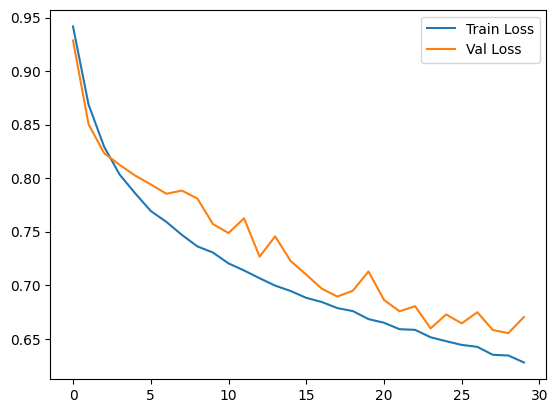

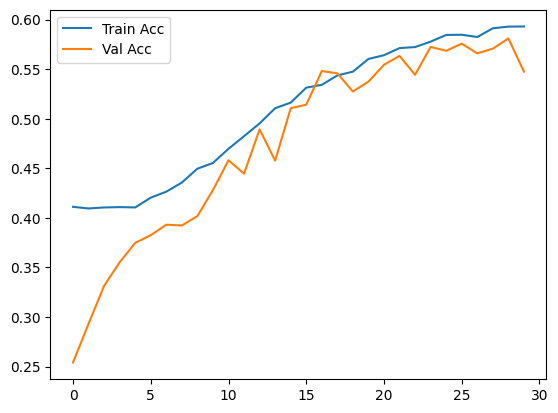

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.show()

plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.show()


In [31]:
import numpy as np

# Dice coefficient
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)  # Threshold 0.5
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# IoU
def iou_score(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [32]:
# X_test: (num_samples, 128, 128, 12)
# Y_test: (num_samples, 128, 128, 1)

Y_pred = model.predict(X_test)  # Output probabilities


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step


In [33]:
dice_scores = []
iou_scores = []

for i in range(len(Y_test)):
    dice = dice_coef(Y_test[i], Y_pred[i])
    iou = iou_score(Y_test[i], Y_pred[i])
    dice_scores.append(dice)
    iou_scores.append(iou)

print("Average Dice coefficient:", np.mean(dice_scores))
print("Average IoU:", np.mean(iou_scores))


Average Dice coefficient: 0.14570405740644465
Average IoU: 0.09567376584726679


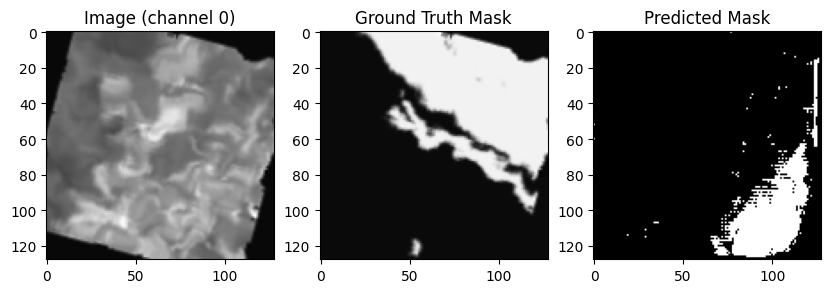

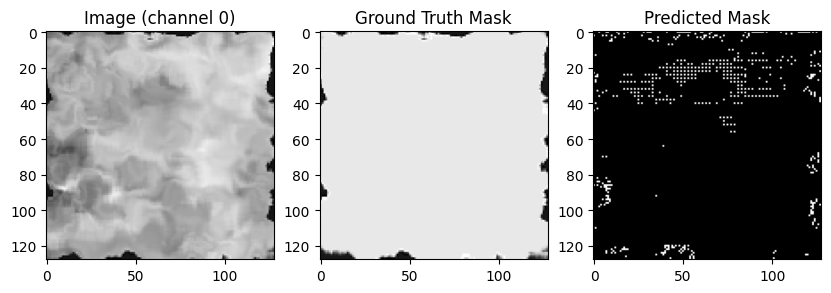

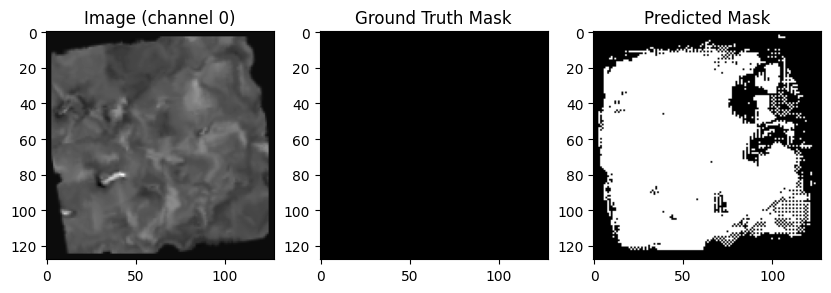

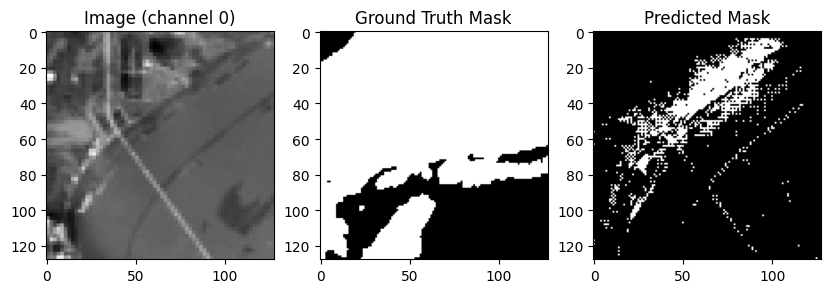

In [35]:
import matplotlib.pyplot as plt

num_samples_to_show = 4
for i in range(num_samples_to_show):
    plt.figure(figsize=(10,3))
    
    # Original image (1st channel for visualization)
    plt.subplot(1,3,1)
    plt.imshow(X_test[i,:,:,0], cmap='gray')
    plt.title("Image (channel 0)")
    
    # Ground truth mask
    plt.subplot(1,3,2)
    plt.imshow(Y_test[i,:,:,0], cmap='gray')
    plt.title("Ground Truth Mask")
    
    # Predicted mask (thresholded at 0.5)
    plt.subplot(1,3,3)
    plt.imshow((Y_pred[i,:,:,0] > 0.5), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()
